In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# %matplotlib notebook

import random
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import KernelDensity
import numpy as np
from numpy.linalg import norm
from mma import *
from multipers import *
from tqdm import tqdm
from benchmark_functions import *

We first generate the data via noise over an anulus

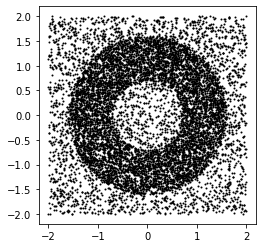

In [2]:
n_pts = 10_000
seed=42
n_outliers = (int)(n_pts * 0.4)
n_pts = (int)(n_pts - n_outliers)
X = np.block([[np.array(noisy_annulus(0.7,1.6,n_pts, seed=seed))],[np.random.uniform(low=-2,high=2,size=(n_outliers,2))]])
# X = np.array(noisy_annulus(1,1.2,n_pts, seed=seed))
fig, ax = plt.subplots()
plt.scatter(X[:,0], X[:,1], c='black', s=1)
ax.set_aspect('equal')
plt.show()

Then we compute an $\alpha$ complex filtration. As you can see, the usual $\alpha$ complex filtration doesn't detect any significant feature; we will add a density estimation to filter features by density to check if we can find the noisy circle.

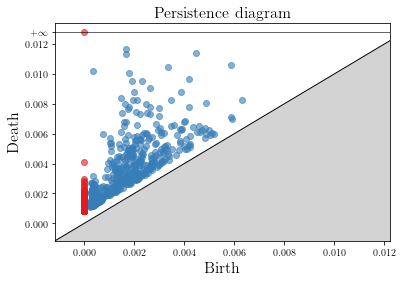

CPU times: user 8.58 s, sys: 24.3 ms, total: 8.6 s
Wall time: 8.65 s


In [3]:
%%time
alpha_complex = gd.AlphaComplex(points=X)
simplex_tree = alpha_complex.create_simplex_tree()
# rips_complex = gd.RipsComplex(points=X)
# simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
# simplex_tree.persistence()
# dgm_alpha = simplex_tree.persistence_intervals_in_dimension()
gd.plot_persistence_diagram(simplex_tree.persistence())
plt.savefig("noisy_annulus_dgm.png", dpi=200)
plt.show()

In [4]:
simplex_tree.num_simplices()

59973

We then compute an approximation of the density via a (gaussian) kernel density estimation (one can choose a simpler filtration to kill the outliers).

<Figure size 432x288 with 0 Axes>

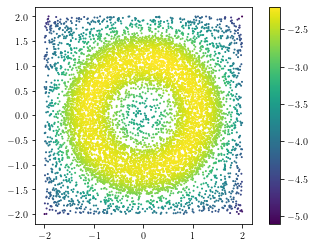

In [5]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=.3).fit(X)
density = kde.score_samples(X)
plt.figure()
fig, ax = plt.subplots()
plt.scatter(X[:,0], X[:,1], c=density, s=1)
ax.set_aspect('equal')
plt.colorbar()
plt.savefig("noisy_annulus_dataset.svg")
plt.show()


We then generate the boundary matrix and associated bifiltration with `ls_boundary_density`. We have to use this function because `filtration_density` is ordered with respect to the points (ie. is already ordered) and the simplices are ordered according to the order given by `Gudhi` (ie. is not ordered and has to be permuted, hence `to_permute = [0]`); this functions ensures that the filtrations and the boundary matrix have the same basis.

If available, this function will call `shapely` instead of `matplotlib` to plot the summands; it is useful when using the `alpha` parameter, as in the other case, it doesn't provide a correct output. 

In [6]:
filtration_density = -np.array(density)
filtration_alpha = np.array([simplex_tree.filtration(s) for s,_ in simplex_tree.get_simplices()])
bifiltration = [filtration_alpha, filtration_density]
box = [[0,1.5],[0.2,4.5]]
precision=0.001
boundary, filters = ls_boundary_density(simplex_tree, bifiltration, to_permute=[0])
len(boundary)

59973

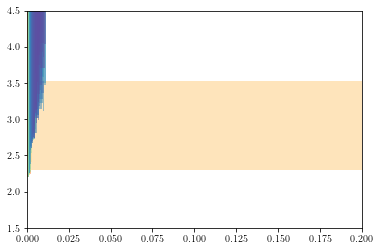

In [7]:
plot_approx_2d(boundary, filters,precision,box=box, dimension=1, separated=0, verbose=0, keep_order=1, min_interleaving =0, complete = 1, alpha = 0.5,save="noisy_annulus_2persistence.svg")
# time_approx(boundary, filters,precision,box=box, verbose=True);

The vertical filtration corresponds to the density and the $\alpha$-complex filtration is the horizontal one. We can see here that we only have 1 signifiant interval summand; which corresponds to the noisy circle. One can use another density filtration such as k-nearest neighbors to have a smaller computational cost.

One can also compute a persistence image (which is bottleneck stable) of this module : 

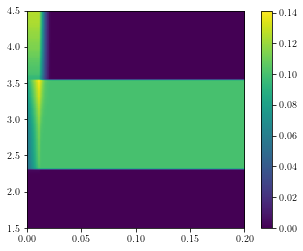

CPU times: user 1min, sys: 266 ms, total: 1min
Wall time: 50.6 s


array([[0.        , 0.        , 0.        , ..., 0.12261104, 0.1227907 ,
        0.12287631],
       [0.        , 0.        , 0.        , ..., 0.12476982, 0.12494948,
        0.12503508],
       [0.        , 0.        , 0.        , ..., 0.12476982, 0.12494948,
        0.12503508],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [8]:
%time persistence_image_2d(boundary, filters,precision,bandwidth=0.01,box=box, dimension=1, verbose=False);

## Convergence wrt increasing precision / number of lines

In [9]:
# convergence_image(boundary, filters, 0.001, 0.001, box=box, num=200, save="Noisy_circle");